# Data Preprocessing

In [350]:
# In[1] ─ Imports & Setup  (unchanged)
import os, urllib.parse, pandas as pd, numpy as np
from dotenv import load_dotenv
from sqlalchemy import create_engine
pd.set_option('display.max_columns', None)

# In[2] ─ Load environment and connect to MySQL  (unchanged)
load_dotenv()
user   = os.getenv("MYSQL_USER")
pw     = urllib.parse.quote_plus(os.getenv("MYSQL_PASSWORD"))
host   = os.getenv("MYSQL_HOST")
port   = os.getenv("MYSQL_PORT")
db     = os.getenv("MYSQL_DATABASE")
engine = create_engine(f"mysql+pymysql://{user}:{pw}@{host}:{port}/{db}")

# -------------------------------------------------------------------
# 1) Load raw tables (unchanged)
ohlcv = pd.read_sql_query(
    "SELECT datetime, open, high, low, close, volume "
    "FROM ohlcv WHERE timeframe='1d'",
    engine, parse_dates=['datetime'], index_col='datetime'
)
ta = pd.read_sql_table(
    'ta_features_1d', engine,
    index_col='datetime', parse_dates=['datetime']
)

# 2) Drop bad TA columns and align start (unchanged)
ta = ta.drop(columns=['TEMA_real', 'TRIX_real'], errors='ignore')
first_valid_dates = [ta[col].first_valid_index() for col in ta.columns]
start_date = max(d for d in first_valid_dates if d is not None)
ta    = ta.loc[start_date:]
ohlcv = ohlcv.loc[start_date:]

# 3) Impute OHLCV & TA fully (unchanged)
ohlcv_ffb = ohlcv.ffill().bfill()
ta_ffb    = ta.ffill().bfill()

# -------------------------------------------------------------------
# 4) **NEW** ─ Build regression target and classification label FIRST
ret1  = ohlcv_ffb['close'].pct_change().rename('ret1')

dir_  = pd.Series(
    np.where(ret1 >= 0, 1, 0),
    index=ret1.index,
    name='dir'
)

# 5) **MODIFIED** ─ Merge everything in ONE concat (prevents fragmentation)
price_cols = ['open', 'high', 'low', 'close', 'volume']
df_all = pd.concat(
    [
        ohlcv_ffb,
        ta_ffb.drop(columns=price_cols),
        ret1,
        dir_                                  # ← classification column
    ],
    axis=1,
    join='inner'
)

# 6) **MODIFIED location** ─ Drop rows where ret1 is NaN (first row)
df_all = df_all.dropna(subset=['ret1'])

# 7) Drop constant columns (run once)
const_cols = [c for c in df_all.columns if df_all[c].nunique() <= 1]
df_all = df_all.drop(columns=const_cols)

# 8) Ensure column names are strings (unchanged)
df_all.columns = df_all.columns.map(str)

# 9) Optional: de‑fragment explicitly (harmless copy)
df_all = df_all.copy()

# -------------------------------------------------------------------
# 10) Quick sanity‑check: class distribution
print("Class distribution:\n", df_all['dir'].value_counts())
df_all.head()


Class distribution:
 dir
0    668
1    655
Name: count, dtype: int64


,open,high,low,close,volume,HT_DCPERIOD_real,HT_DCPHASE_real,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE_integer,ADD_real,DIV_real,MAX_real,MAXINDEX_integer,MIN_real,MININDEX_integer,MINMAX_min,MINMAX_max,MINMAXINDEX_minidx,MINMAXINDEX_maxidx,MULT_real,SUB_real,SUM_real,ATAN_real,CEIL_real,COS_real,FLOOR_real,LN_real,LOG10_real,SIN_real,SQRT_real,TAN_real,ADX_real,ADXR_real,APO_real,AROON_aroondown,AROON_aroonup,AROONOSC_real,BOP_real,CCI_real,CMO_real,DX_real,MACD_macd,MACD_macdsignal,MACD_macdhist,MACDEXT_macd,MACDEXT_macdsignal,MACDEXT_macdhist,MACDFIX_macd,MACDFIX_macdsignal,MACDFIX_macdhist,MFI_real,MINUS_DI_real,MINUS_DM_real,MOM_real,PLUS_DI_real,PLUS_DM_real,PPO_real,ROC_real,ROCP_real,ROCR_real,ROCR100_real,RSI_real,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,ULTOSC_real,WILLR_real,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA_real,EMA_real,HT_TRENDLINE_real,KAMA_real,MA_real,MAMA_mama,MAMA_fama,MIDPOINT_real,MIDPRICE_real,SAR_real,SAREXT_real,SMA_real,T3_real,TRIMA_real,WMA_real,CDLADVANCEBLOCK_integer,CDLBELTHOLD_integer,CDLCLOSINGMARUBOZU_integer,CDLDOJI_integer,CDLDRAGONFLYDOJI_integer,CDLENGULFING_integer,CDLGRAVESTONEDOJI_integer,CDLHAMMER_integer,CDLHANGINGMAN_integer,CDLHARAMI_integer,CDLHARAMICROSS_integer,CDLHIGHWAVE_integer,CDLHIKKAKE_integer,CDLHIKKAKEMOD_integer,CDLLONGLEGGEDDOJI_integer,CDLLONGLINE_integer,CDLMARUBOZU_integer,CDLMATCHINGLOW_integer,CDLRICKSHAWMAN_integer,CDLSEPARATINGLINES_integer,CDLSHORTLINE_integer,CDLSPINNINGTOP_integer,CDLSTALLEDPATTERN_integer,CDLTAKURI_integer,AVGPRICE_real,MEDPRICE_real,TYPPRICE_real,WCLPRICE_real,BETA_real,CORREL_real,LINEARREG_real,LINEARREG_ANGLE_real,LINEARREG_INTERCEPT_real,LINEARREG_SLOPE_real,STDDEV_real,TSF_real,VAR_real,ATR_real,NATR_real,TRANGE_real,AD_real,ADOSC_real,OBV_real,ret1,dir
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-07,52586.77,52818.37,43000.00,46729.20,645.126118,18.635134,193.171459,1185.709987,2640.824360,-0.227866,-0.849630,1.0,95818.37,1.228334,52586.77,63.0,44412.00,38.0,44412.00,52586.77,38.0,63.0,2.271190e+09,9818.37,1435656.54,1.570775,46730.0,0.407693,46729.0,10.752125,4.669588,0.913119,216.169378,2.239724,28.294841,33.776386,919.061795,100.000000,100.000000,0.0,-0.596593,-82.288544,-4.450960,22.825941,1588.845268,1844.472121,-255.626853,919.061795,1182.885726,-263.823932,1517.644555,1762.038593,-244.394038,59.821484,29.733322,10900.650538,-2155.64,18.682056,6849.102442,1.905808,-4.409629,-0.044096,0.955904,95.590371,47.774520,78.052107,84.235899,37.981865,78.052107,0.000000,66.666667,56.246084,-62.018135,54207.512275,50187.278,46167.043725,51260.777269,47019.503009,48206.442387,47599.349994,47855.218000,48169.377335,47496.809775,49657.985,47909.185,52818.370000,-52818.370000,47855.218000,50338.783665,47942.271542,48607.124688,0.0,0.0,0.0,0.0,0.0,-80.0,0.0,0.0,0.0,0.0,0.0,0.0,-200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48783.5850,47909.185,47515.856667,47319.1925,1.280292,0.687029,50108.163714,89.673638,47825.924857,175.556835,2010.117137,50283.720549,4.040571e+06,2620.988328,5.608888,9818.37,1103.680104,133.580534,1048.136021,-0.111389,0
2021-09-08,46729.20,47299.87,44436.94,46014.25,407.756328,18.475897,197.380038,1927.090095,1588.805912,-0.298708,-0.886042,1.0,91736.81,1.064427,52586.77,63.0,44412.00,38.0,44412.00,52586.77,38.0,63.0,2.101861e+09,2862.93,1435385.46,1.570775,46015.0,-0.791463,46014.0,10.736706,4.662892,0.611217,214.509324,-0.772262,27.904205,32.846811,736.058462,92.857143,92.857143,0.0,-0.249727,-147.476793,-8.106458,22.825941,1218.622897,1719.302276,-500.679379,736.058462,1065.713903,-329.655442,1168.501409,1643.331156,-474.829747,51.103176,27.426780,10122.032642,-2742.33,17.232809,6359.880839,1.528511,-5.624533,-0.056245,0.943755,94.375467,45.946771,55.639083,74.829356,30.700106,55.639083,0.000000,33.333333,53.55

<Axes: title={'center': 'BTCUSDT Price Direction Data'}, xlabel='datetime'>

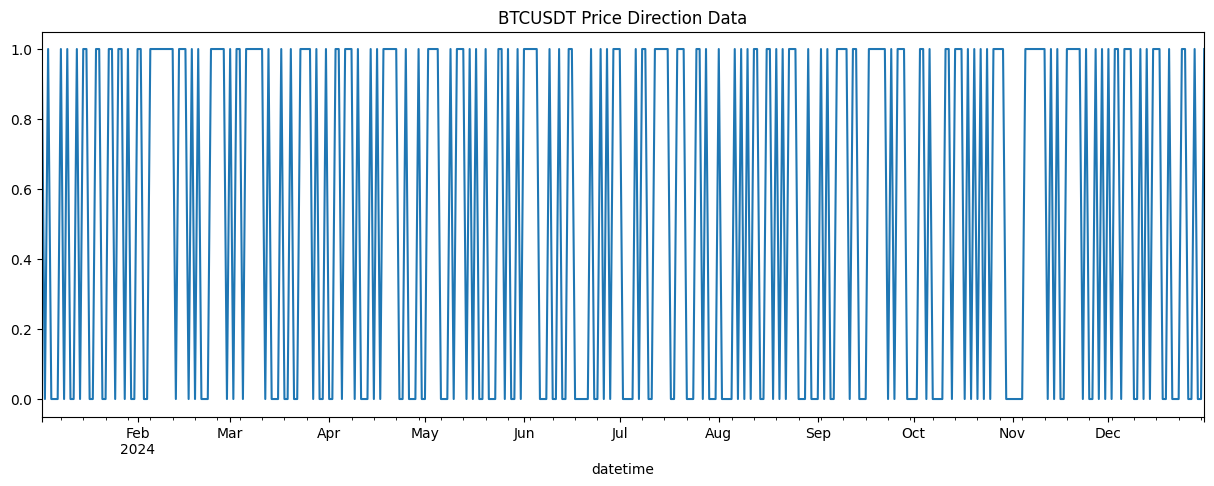

In [351]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
df_all['dir'].loc[(df_all.index > '2024-01-01') & (df_all.index < '2025-01-01')].plot(ax=ax,title='BTCUSDT Price Direction Data')

# Feature Engineering and Selection

## Scaling

In [352]:
import pandas as pd, numpy as np
from sklearn.preprocessing   import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import mutual_info_classif

# ── CONFIG ─────────────────────────────────────────────────────────────
TARGET      = 'dir'
MAX_LAG     = 14
N_SPLITS    = 3
KEEP_PCT    = 0.30

# 1) Prepare X_final, y (mutual-info lag selection) ─────────────────────
y  = df_all[TARGET]
X0 = df_all.drop(columns=[TARGET])

# 2) build lags 1…MAX_LAG
frames = [X0.shift(L).add_suffix(f'_lag{L}') for L in range(1, MAX_LAG+1)]
X_lag = pd.concat(frames, axis=1).dropna()
y     = y.loc[X_lag.index]

# 3) Apply Robust standardization to features(X) ────────────────────────
scaler = RobustScaler()
X_lag_scaled = pd.DataFrame(scaler.fit_transform(X_lag),index=X_lag.index,columns=X_lag.columns)

## Feature Selection Method 1: Mutual Information using KNN

In [353]:
# 1) avg MI over folds ──────────────────────────────────────────────────
mi = pd.Series(0.0, index=X_lag_scaled.columns)
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
for tr, _ in tscv.split(X_lag_scaled):
    mi  += mutual_info_classif(X_lag_scaled.iloc[tr], y.iloc[tr], discrete_features=False)
mi /= N_SPLITS

# 2) keep top KEEP_PCT of lags ──────────────────────────────────────────
k        = int(len(mi) * KEEP_PCT)
top_feats= mi.nlargest(k).index
X_reduced    = X_lag_scaled[top_feats]
X_reduced

,HT_SINE_leadsine_lag2,MACDFIX_macdhist_lag3,CMO_real_lag6,RSI_real_lag6,ADX_real_lag6,MACDEXT_macdsignal_lag1,MACDEXT_macdhist_lag1,TYPPRICE_real_lag9,ADX_real_lag1,DIV_real_lag1,OBV_real_lag2,HT_PHASOR_quadrature_lag14,AROON_aroonup_lag3,ATR_real_lag10,COS_real_lag9,DIV_real_lag10,ROC_real_lag10,ROCP_real_lag10,ROCR_real_lag10,ROCR100_real_lag10,CEIL_real_lag2,ADXR_real_lag5,DEMA_real_lag6,FLOOR_real_lag2,SQRT_real_lag2,LN_real_lag2,LOG10_real_lag2,HT_SINE_sine_lag9,open_lag1,close_lag2,MIDPRICE_real_lag8,DIV_real_lag5,VAR_real_lag8,OBV_real_lag3,ATAN_real_lag2,CDLGRAVESTONEDOJI_integer_lag14,STDDEV_real_lag8,CDLHIKKAKE_integer_lag8,MACDFIX_macd_lag4,SUB_real_lag5,TRANGE_real_lag5,ROC_real_lag4,ROCP_real_lag4,ROCR_real_lag4,ROCR100_real_lag4,BBANDS_middleband_lag1,TSF_real_lag10,APO_real_lag4,MACDEXT_macd_lag4,BBANDS_upperband_lag13,WCLPRICE_real_lag6,BBANDS_upperband_lag1,PPO_real_lag11,APO_real_lag11,MACDEXT_macd_lag11,HT_TRENDMODE_integer_lag3,DX_real_lag2,MULT_real_lag5,STOCH_slowd_lag11,ADXR_real_lag4,MACD_macd_lag4,AROONOSC_real_lag5,CDLHAMMER_integer_lag10,DIV_real_lag8,STOCHRSI_fastd_lag5,PPO_real_lag10,CMO_real_lag9,RSI_real_lag9,ret1_lag3,MACD_macdhist_lag3,MACDEXT_macdsignal_lag13,ADOSC_real_lag6,MACDFIX_macdsignal_lag1,EMA_real_lag14,WCLPRICE_real_lag9,HT_PHASOR_inphase_lag10,CDLTAKURI_integer_lag6,WILLR_real_lag4,TAN_real_lag1,STOCH_slowd_lag13,TSF_real_lag7,MINUS_DM_real_lag13,AVGPRICE_real_lag6,HT_SINE_leadsine_lag9,MFI_real_lag5,SUM_real_lag1,MA_real_lag1,SMA_real_lag1,ADD_real_lag5,MEDPRICE_real_lag5,SIN_real_lag5,WILLR_real_lag1,CDLHARAMI_integer_lag3,HT_PHASOR_inphase_lag12,CDLHIKKAKE_integer_lag12,CDLSEPARATINGLINES_integer_lag6,MACD_macdhist_lag2,low_lag10,MACD_macdsignal_lag1,HT_SINE_leadsine_lag7,LINEARREG_INTERCEPT_real_lag4,ADD_real_lag2,MEDPRICE_real_lag2,OBV_real_lag9,MINMAX_max_lag8,CDLHARAMICROSS_integer_lag6,ATAN_real_lag1,CMO_real_lag8,RSI_real_lag8,HT_DCPHASE_real_lag2,volume_lag10,MACD_macdhist_lag12,CDLDRAGONFLYDOJI_integer_lag6,close_lag1,low_lag11,HT_TRENDMODE_integer_lag6,SAR_real_lag8,SQRT_real_lag1,CEIL_real_lag1,LN_real_lag1,LOG10_real_lag1,PLUS_DI_real_lag6,CDLSPINNINGTOP_integer_lag13,FLOOR_real_lag1,MAMA_mama_lag5,HT_DCPHASE_real_lag9,CDLADVANCEBLOCK_integer_lag7,LINEARREG_INTERCEPT_real_lag3,TSF_real_lag11,MACDFIX_macdsignal_lag3,STOCH_slowk_lag5,STOCHF_fastd_lag5,ROC_real_lag13,ROCP_real_lag13,ROCR_real_lag13,ROCR100_real_lag13,HT_DCPERIOD_real_lag5,MACDFIX_macdhist_lag2,PLUS_DM_real_lag11,MULT_real_lag2,CDLHIGHWAVE_integer_lag13,CDLENGULFING_integer_lag10,CDLLONGLEGGEDDOJI_integer_lag6,CEIL_real_lag9,CDLADVANCEBLOCK_integer_lag4,CDLRICKSHAWMAN_integer_lag4,CDLHARAMICROSS_integer_lag14,FLOOR_real_lag9,MIDPOINT_real_lag7,CDLSHORTLINE_integer_lag13,CDLHANGINGMAN_integer_lag2,CDLHANGINGMAN_integer_lag13,ATAN_real_lag9,CDLGRAVESTONEDOJI_integer_lag12,CDLGRAVESTONEDOJI_integer_lag2,WILLR_real_lag5,WILLR_real_lag11,CCI_real_lag10,open_lag8,close_lag9,CDLDOJI_integer_lag10,MAXINDEX_integer_lag5,CDLDOJI_integer_lag2,STOCHF_fastk_lag13,CDLGRAVESTONEDOJI_integer_lag13,SQRT_real_lag9,AD_real_lag1,CDLDOJI_integer_lag1,TAN_real_lag2,LN_real_lag9,LOG10_real_lag9,BOP_real_lag2,ret1_lag8,MINMAX_max_lag4,STDDEV_real_lag14,BETA_real_lag9,MACD_macd_lag12,STOCHRSI_fastd_lag8,MIDPRICE_real_lag6,CDLHARAMI_integer_lag10,TAN_real_lag7,CDLDRAGONFLYDOJI_integer_lag12,ULTOSC_real_lag5,ret1_lag10,ADD_real_lag9,MEDPRICE_real_lag9,ret1_lag5,CDLBELTHOLD_integer_lag4,SIN_real_lag4,CMO_real_lag5,RSI_real_lag5,CMO_real_lag2,RSI_real_lag2,AROON_aroonup_lag9,VAR_real_lag14,T3_real_lag8,DX_real_lag5,DIV_real_lag11,STOCH_slowd_lag8,CDLLONGLINE_integer_lag12,CDLHIKKAKE_integer_lag11,CDLCLOSINGMARUBOZU_integer_lag3,MACD_macdsignal_lag13,CDLSTALLEDPATTERN_integer_lag4,CDLHARAMI_integer_lag14,CDLHAMMER_integer_lag7,MOM_real_lag13,LINEARREG_ANGLE_real_lag5,HT_SINE_leadsine_lag12,MACD_macdhist_lag10,HT_PHASOR_inphase_lag6,LINEARREG_SLOPE_real_lag5,MIDPRICE_real_lag5,CDLBELTHOLD_integer_lag13,HT_SINE_sine_lag2,CORREL_real_la

## Feature Selection Method 2: Boruta

In [354]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# --- 1) Set up a RandomForest with enough trees ----------------------------
rf = RandomForestClassifier(
    n_estimators=1000,        # BorutaPy will actually override this with 'auto'
    max_depth=3,
    n_jobs=-1,
    random_state=42
)

# --- 2) Wrap in BorutaPy ---------------------------------------------------
boruta = BorutaPy(
    estimator=rf,
    n_estimators=1000,        # let Boruta pick a sufficient forest size
    verbose=False,              # shows you progress of the shadow‐feature tests
    random_state=42,
)

# --- 3) Fit on your training data ------------------------------------------
# Pass the raw values; BorutaPy does its own internal shadow‐feature testing
boruta.fit(X_reduced.values, y.values)

# --- 4) Extract and rank all features by Boruta rank ------------------------
# boruta.ranking_: array of ints, 1 = confirmed important, ↑ = less important
ranks = pd.Series(boruta.ranking_, index=X_reduced.columns)

# Sort ascending (1 = best), then take the top 10 names
boruta_selected_mc = ranks.sort_values().head(10).index.tolist()
X_boruta = X_reduced[boruta_selected_mc].copy() 

print("Top 10 features by Boruta rank:")
for i, feat in enumerate(boruta_selected_mc, 1):
    print(f"{i:2d}. {feat} (rank={ranks[feat]})")


Top 10 features by Boruta rank:
 1. ret1_lag9 (rank=2)
 2. STOCHF_fastk_lag1 (rank=3)
 3. DIV_real_lag5 (rank=4)
 4. ret1_lag1 (rank=5)
 5. ret1_lag5 (rank=6)
 6. STOCHF_fastk_lag9 (rank=7)
 7. OBV_real_lag1 (rank=8)
 8. MACDFIX_macdhist_lag1 (rank=9)
 9. HT_SINE_sine_lag3 (rank=9)
10. HT_SINE_leadsine_lag4 (rank=11)


# Machine Learning 

## Train, Test datasets

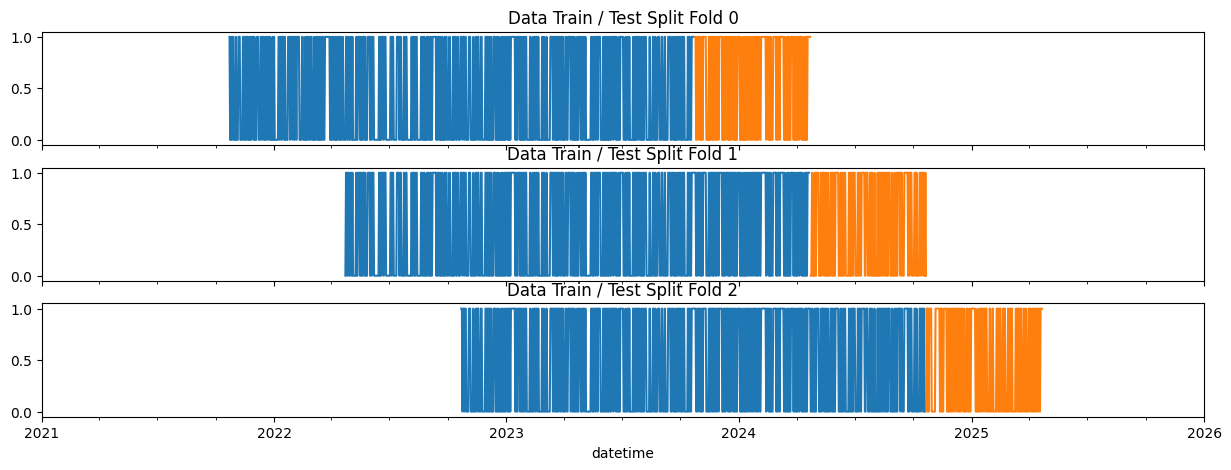

In [380]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Prepare X and y
X = X_boruta.copy()   
y = y.copy()

# TimeSeriesSplit
n_splits = 3
train_window_size = int(365*2)
val_window_size = int(365/2)
train_val_gap = 1
tss = TimeSeriesSplit(n_splits, test_size=val_window_size, gap=train_val_gap)

fig, axs = plt.subplots(n_splits,1,figsize=(15,5),sharex=True)
fold = 0
for train_idx, val_idx in tss.split(X):
    train_idx = train_idx[-train_window_size:-1]

    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]

    y_train.plot(ax=axs[fold], label='Training set', title=f'Data Train / Test Split Fold {fold}')
    y_val.plot(ax=axs[fold], label='Test Set')
    fold += 1
    
for ax in axs:
    ax.set_xlim('2021-01-01', '2026-01-01')
plt.show()

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
# import pandas as pd

# # 1) Prepare X and y
# X = X_boruta.copy()   
# y = y.copy()

# split_idx = int(0.6*len(X))
# X_train = X.iloc[:split_idx]
# y_train = y.iloc[:split_idx]

# X_val = X.iloc[split_idx+1:]
# y_val = y.iloc[split_idx+1:]

# clf = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     # use_label_encoder=False,
#     random_state=42,
#     n_jobs=-1,

#     # Complexity control
#     n_estimators=10000,          # start big, prune with ES
#     early_stopping_rounds=50,   # stop if no val-loss improvement for 50 rounds
#     max_depth=3,                # shallow trees generalize better
#     learning_rate=0.001,         # smaller step size → smoother fit
#     subsample=0.8,              # row sampling
#     colsample_bytree=0.8,       # feature sampling

#     # Split regularization
#     gamma=1.0,                  # min loss reduction to make a split
#     min_child_weight=5,         # min sum hessian in a leaf

#     # Weight regularization
#     reg_alpha=1.,              # L1
#     reg_lambda=1.5,             # L2
# )

# clf.fit(
#     X_train, y_train,
#     eval_set=[(X_train, y_train), (X_val, y_val)],
#     verbose=100,
# )

In [404]:
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import log_loss

# 1) set up your grid (or use random.sample on ParameterGrid for a cheap random search)
param_grid = {
    'max_depth':       [3, 5, 7],
    'learning_rate':   [0.001, 0.01],
    'subsample':       [0.5, 0.7, 1],
    'colsample_bytree':[0.5, 0.7, 1],
    'gamma':           [0.],
    'min_child_weight':[1, 3, 5, 7],
    'reg_alpha':       [0, 0.5, 1, 1.5],
    'reg_lambda':      [0, 0.5, 1, 1.5],
}

best_score = np.inf
best_params = None

for params in ParameterGrid(param_grid):
    fold_scores = []
    for train_idx, val_idx in tss.split(X):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_va, y_va = X.iloc[val_idx], y.iloc[val_idx]

        clf = XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1,
            early_stopping_rounds=50,
            n_estimators=10000,
            **params
        )
        clf.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            verbose=False
        )

        # record logloss on this fold’s best iteration
        proba = clf.predict_proba(X_va)[:, 1]
        fold_scores.append(log_loss(y_va, proba))

    mean_score = np.mean(fold_scores)
    if mean_score < best_score:
        best_score, best_params = mean_score, params
        print(f"New best: {best_score:.5f} with {best_params}")

print("▶ Final best logloss:", best_score)
print("▶ Final best params:", best_params)


New best: 0.68697 with {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.5}
New best: 0.68655 with {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}
New best: 0.68638 with {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5}
New best: 0.68583 with {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.5}
New best: 0.68350 with {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.5}
New best: 0.68342 with {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weigh

In [405]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Prepare X and y
X = X_boruta.copy()   
y = y.copy()

fold = 0
preds = {}
probs = {}
vals = {}
fis = {}

for train_idx, val_idx in tss.split(X):
    print(f'================== fold {fold} ==================')

    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]

    clf = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        # use_label_encoder=False,
        random_state=42,
        n_jobs=-1,

        # Complexity control
        n_estimators=10000,          # start big, prune with ES
        early_stopping_rounds=50,   # stop if no val-loss improvement for 50 rounds
        max_depth=5,                # shallow trees generalize better
        learning_rate=0.01,         # smaller step size → smoother fit
        subsample=1.,              # row sampling
        colsample_bytree=1.,       # feature sampling

        # Split regularization
        gamma=0.,                  # min loss reduction to make a split
        min_child_weight=7,         # min sum hessian in a leaf

        # Weight regularization
        reg_alpha=0.5,              # L1
        reg_lambda=0.,             # L2
    )

    clf.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100,
    )

    # Result Collection
    preds[fold]= clf.predict(X_val)
    probs[fold] = clf.predict_proba(X_val)
    vals[fold] = y_val
    fis[fold] = {'feature_importances_': clf.feature_importances_, 'feature_names_in_': clf.feature_names_in_}

    fold += 1

================== fold 0 ==================
[0]	validation_0-logloss:0.69068	validation_1-logloss:0.70268


[100]	validation_0-logloss:0.61778	validation_1-logloss:0.69082
[130]	validation_0-logloss:0.60424	validation_1-logloss:0.69279
================== fold 1 ==================
[0]	validation_0-logloss:0.69222	validation_1-logloss:0.69261
[100]	validation_0-logloss:0.63665	validation_1-logloss:0.67449
[200]	validation_0-logloss:0.59861	validation_1-logloss:0.67059
[242]	validation_0-logloss:0.58487	validation_1-logloss:0.67217
================== fold 2 ==================
[0]	validation_0-logloss:0.69212	validation_1-logloss:0.69353
[100]	validation_0-logloss:0.63426	validation_1-logloss:0.68824
[124]	validation_0-logloss:0.62376	validation_1-logloss:0.68950


In [368]:
# fi = pd.DataFrame(data = clf.feature_importances_,
#                   index = clf.feature_names_in_,
#                   columns = ['importance'])
# fi.sort_values('importance').plot(kind='barh')

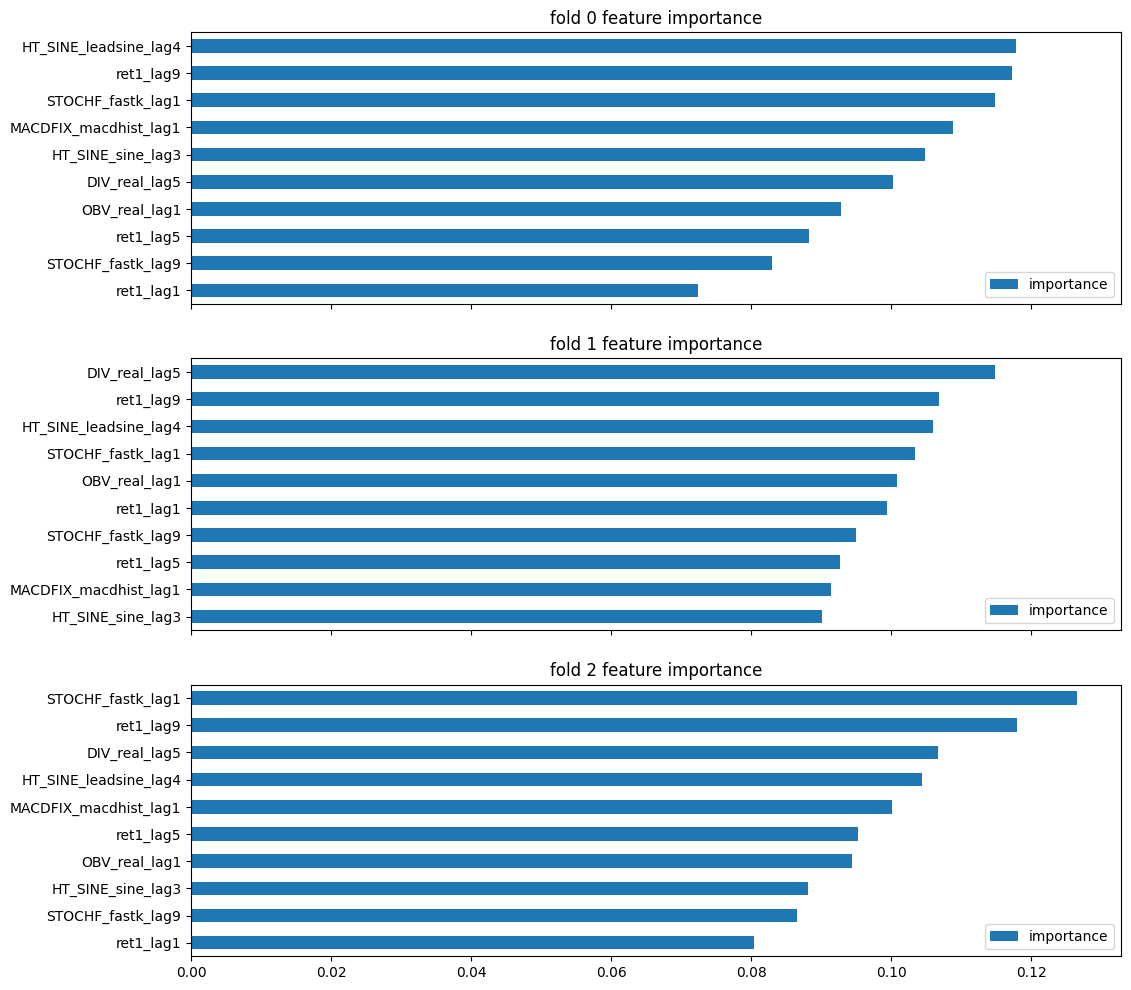

In [406]:
fig, axs = plt.subplots(n_splits,1,figsize=(12,12),sharex=True)

for fold in range(n_splits):
    fi = pd.DataFrame(data = fis[fold]['feature_importances_'],
                      index = fis[fold]['feature_names_in_'],
                      columns = ['importance'])
    fi.sort_values('importance').plot(ax=axs[fold], title=f'fold {fold} feature importance', kind='barh')
    
plt.show()

In [369]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # 1) Predict labels on the validation set
# y_pred = clf.predict(X_val)

# # 2) Compute accuracy
# val_accuracy = accuracy_score(y_val, y_pred)
# print(f"Validation accuracy: {val_accuracy:.4f}")

# # 3) (Optional) More diagnostics
# print("\nClassification Report:")
# print(classification_report(y_val, y_pred))

# print("\nConfusion Matrix:")
# print(confusion_matrix(y_val, y_pred))


In [407]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


for fold in range(n_splits):
    # 1) Recall predicted and actual y outputs
    y_pred = preds[fold]
    y_val = vals[fold]

    # 2) Compute accuracy
    val_accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation accuracy: {val_accuracy:.4f}")

    # 3) (Optional) More diagnostics
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

Validation accuracy: 0.5330

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.95      0.63        76
           1       0.86      0.24      0.37       106

    accuracy                           0.53       182
   macro avg       0.67      0.59      0.50       182
weighted avg       0.70      0.53      0.48       182


Confusion Matrix:
[[72  4]
 [81 25]]
Validation accuracy: 0.5659

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.65      0.61        94
           1       0.56      0.48      0.52        88

    accuracy                           0.57       182
   macro avg       0.57      0.56      0.56       182
weighted avg       0.57      0.57      0.56       182


Confusion Matrix:
[[61 33]
 [46 42]]
Validation accuracy: 0.5055

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.71      0.58        89
     

In [389]:
# # 1) Predict labels on the validation set
# y_proba = clf.predict_proba(X_val)
# y_proba = y_proba.max(axis=1)

# # 1) Predict labels on the validation set
# y_pred = clf.predict(X_val)
# y_pred_confident = y_pred[y_proba>0.56]
# y_test_confident = y_val[y_proba>0.56]

# # 2) Compute accuracy
# val_accuracy = accuracy_score(y_test_confident, y_pred_confident)
# print(f"Validation accuracy: {val_accuracy:.4f}")

# # 3) (Optional) More diagnostics
# print("\nClassification Report:")
# print(classification_report(y_test_confident, y_pred_confident))

# print("\nConfusion Matrix:")
# print(confusion_matrix(y_test_confident, y_pred_confident))

In [408]:
for fold in range(n_splits):
    y_proba = probs[fold]
    y_proba = y_proba.max(axis=1)

    y_pred = preds[fold]
    y_val = vals[fold]

    y_pred_confident = y_pred[y_proba>0.56]
    y_test_confident = y_val[y_proba>0.56]

    # 2) Compute accuracy
    val_accuracy = accuracy_score(y_test_confident, y_pred_confident)
    print(f"Validation accuracy: {val_accuracy:.4f}")

    print(f"percentage of trade occured per 1d data: {len(y_test_confident)/len(y_val)*100:.3}%")

    # 3) (Optional) More diagnostics
    print("\nClassification Report:")
    print(classification_report(y_test_confident, y_pred_confident))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_confident, y_pred_confident))

Validation accuracy: 0.5714
percentage of trade occured per 1d data: 53.8%

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.98      0.70        49
           1       0.89      0.16      0.28        49

    accuracy                           0.57        98
   macro avg       0.71      0.57      0.49        98
weighted avg       0.71      0.57      0.49        98


Confusion Matrix:
[[48  1]
 [41  8]]
Validation accuracy: 0.6437
percentage of trade occured per 1d data: 47.8%

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        43
           1       0.68      0.57      0.62        44

    accuracy                           0.64        87
   macro avg       0.65      0.64      0.64        87
weighted avg       0.65      0.64      0.64        87


Confusion Matrix:
[[31 12]
 [19 25]]
Validation accuracy: 0.5893
percentage of trade occured per 1d data: 30.